In [1]:
%matplotlib inline

In [2]:
from lab_tsp_insertion import *
import math
import matplotlib.pyplot as plt
import sys

In [30]:
from functools import lru_cache
class TSPSolution(object):
    def __init__(self, instance: list, tour:list, distance:int):
        self.tour = tour
        self.n_cities = len(tour)
        self.inst = instance
        self.distance = self.calculate_solution_distance()
    
    def __repr__(self):
        return f"Tour={self.tour}, distance={self.distance}, n_cities={self.n_cities}"
    
    def get_n_cities(self):
        return self.n_cities
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def get_distance(self, x, y):
        # This function takes the city number, not index into array
        c1x, c1y = self.inst[x]
        c2x, c2y = self.inst[y]
        return ((c2x - c1x) ** 2 + (c2y - c1y) ** 2)
    
    def copy(self):
        return TSPSolution(self.inst, self.tour.copy(), self.distance)
    
    @lru_cache(maxsize=1024 * 1024 * 1024)
    def is_valid_swap(self, x:int, y:int):
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        return x != y and x != y1 and x != x1 and y != y1 and y != x1 and y1 != x1
    
    def calculate_cost_if_swapped(self, x:int, y: int):
        # If the edges are swapped what would be the cost
        x, y = min(x, y), max(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        xx1 = self.get_distance(self.tour[x], self.tour[x1])
        xy = self.get_distance(self.tour[x], self.tour[y])
        yy1 = self.get_distance(self.tour[y], self.tour[y1])
        x1y1 = self.get_distance(self.tour[x1], self.tour[y1])
        return self.distance - xx1 - yy1 + x1y1 + xy
    
    def get_cache_stats(self):
        return self.get_distance.cache_info(), self.is_valid_swap.cache_info()
    
    def calculate_solution_distance(self):
        dist = 0
        for x in range(self.n_cities):
            y = (x + 1) % self.n_cities
            dist += self.get_distance(self.tour[x], self.tour[y])
        return dist
    
    def perform_swap(self, x, y):
        x, y = min(x, y), max(x, y)
        new_distance = self.calculate_cost_if_swapped(x, y)
        x1 = (x + 1) % self.n_cities
        y1 = (y + 1) % self.n_cities
        assert(x1 < y)
        self.tour[x1], self.tour[y] = self.tour[y], self.tour[x1]
        i = x1 + 1
        j = y - 1
        while (i < j):
            self.tour[i], self.tour[j] = self.tour[j], self.tour[i]
            i += 1
            j -= 1
        #if int(self.calculate_solution_distance()) != int(new_distance):
        #    print(f"New distance should have been {new_distance} but is {self.calculate_solution_distance()}")
        self.distance = new_distance


In [87]:
class TSPHillClimbing(object):
    def __init__(self, inst:dict = None, max_sideways_moves:int=0):
        self.inst = inst
        self.ind = None
        self.g_best_solution = None
        self.g_best_distance = 99999999999999999999999999999999999999999
        self.current_iter_sols = []
        self.current_iter_dist = None
        self.max_sideways_moves = max_sideways_moves
        self.n_sideways_moves = 0
        self.g_best_distance = 999999999999999999999999999999999999999999
        self.g_best_sol = None
        if None != self.inst:
            self.ind = self.get_solution()
            self.update_best_g_instance(self.ind)

            
    def __repr__(self):
        return f"inst = {self.inst}\n\nindividual = {self.ind}\n\n" +\
             f"g_best_solution = {self.g_best_solution}\n\ng_best_distance = {self.g_best_distance}"
    
    def update_best_g_instance(self, instance: TSPSolution):
        self.g_best_solution = instance.copy()
        self.g_best_distance = instance.distance
        
    def get_solution(self):
        #cities, distance = insertion_heuristic1(self.inst)
        cities, distance = randomTours(self.inst)
        return TSPSolution(self.inst, cities, distance)
    
    def check_improving_move(self):
        self.current_iter_dist = self.ind.distance
        self.current_iter_sols = []
        for i in range(self.ind.get_n_cities()):
            for j in range(i+2, self.ind.get_n_cities()):
                if not self.ind.is_valid_swap(i, j):
                    pass
                else:
                    newcost = self.ind.calculate_cost_if_swapped(i, j)
                    if newcost == self.current_iter_dist:
                        self.current_iter_sols.append(list(i, j))
                    elif newcost < self.current_iter_dist:
                        self.current_iter_dist = newcost
                        self.current_iter_sols = [[i,j]]
    
    def iterate_once(self, allow_sideways=False):
        update = False
        old_distance = self.ind.distance
        self.check_improving_move()
        if old_distance == self.current_iter_dist:
            if not allow_sideways or len(self.current_iter_sols) == 0:
                print("All moves are worse")
                return old_distance, self.current_iter_dist, True
            else:
                print("Performing sideways move", self.n_sideways_moves + 1)
                self.n_sideways_moves += 1
                update = True
        if int(self.ind.distance) > int(self.current_iter_dist):
            self.n_sideways_moves = 0
            update = True
        if update:
            toswap = self.current_iter_sols[random.randint(0, len(self.current_iter_sols)-1)]
            x, y = tuple(toswap)
            self.ind.perform_swap(x, y)
        return old_distance, self.current_iter_dist, False
        
    def iterate(self, n_iterations, allow_sideways=False, max_sideways_moves=-1):
        y = []
        rt = []
        self.n_sideways_moves = 0
        t1 = time.perf_counter()
        for i in range(n_iterations):
            sys.stdout.write('.')
            old_distance, current_iter_dist, all_moves_worse = self.iterate_once(allow_sideways)
            if 0 == i:
                y.append(math.sqrt(old_distance))
            rt.append(time.perf_counter() - t1)
            y.append(math.sqrt(current_iter_dist))
            if old_distance == current_iter_dist:
                print(self.n_sideways_moves)
                if all_moves_worse or not allow_sideways or max_sideways_moves < self.n_sideways_moves:
                    if allow_sideways:
                        print("Reached maximum sideways moves")
                    break
            sys.stdout.write(" %f " % (math.sqrt(old_distance) - math.sqrt(current_iter_dist)))
        print("iterations done: ", i)
        print('-' * 80)
        fig, ax = plt.subplots(2)
        ax[0].plot(y, label='distance')
        ax[1].plot(rt, label='runtime')
        #print(rt, y)
        fig.legend()
        plt.show()
        
    def restart_and_iterate(self, n_iterations=100, n_restarts:int=5, allow_sideways=False, max_sideways_moves=-1):
        for i in range(n_restarts):
            self.ind = self.get_solution()
            #print(math.sqrt(self.ind.distance))
            self.update_best_g_instance(self.ind)
            self.iterate(n_iterations, allow_sideways, max_sideways_moves)
            #print(math.sqrt(self.ind.distance))
                

In [98]:
class TSPHillClimbingRandomIprovement(TSPHillClimbing):
    def iterate_once(self, allow_sideways=False):
        print("--- iterating once")
        return True, True, True
    pass

In [99]:
random.seed(5)
def main():
    inst = readInstance('TSPData/inst-0.tsp')
    tsp = TSPHillClimbingRandomIprovement(inst)
    tsp.restart_and_iterate(10000, 5, True, 10)
    print('-' * 80)
    return tsp

.--- iterating once
0
Reached maximum sideways moves
iterations done:  0
--------------------------------------------------------------------------------


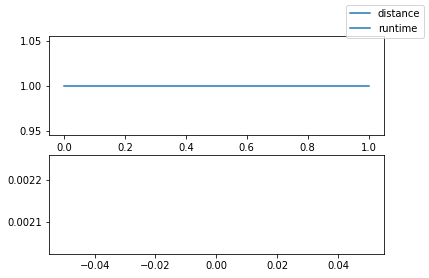

.--- iterating once
0
Reached maximum sideways moves
iterations done:  0
--------------------------------------------------------------------------------


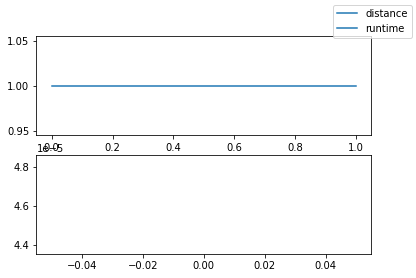

.--- iterating once
0
Reached maximum sideways moves
iterations done:  0
--------------------------------------------------------------------------------


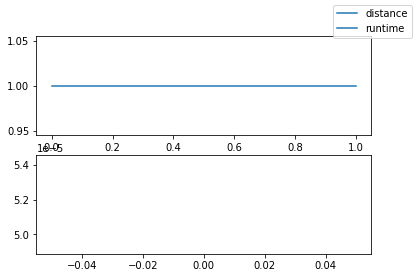

.--- iterating once
0
Reached maximum sideways moves
iterations done:  0
--------------------------------------------------------------------------------


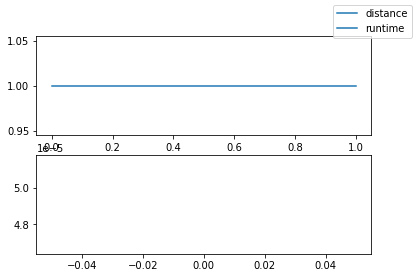

.--- iterating once
0
Reached maximum sideways moves
iterations done:  0
--------------------------------------------------------------------------------


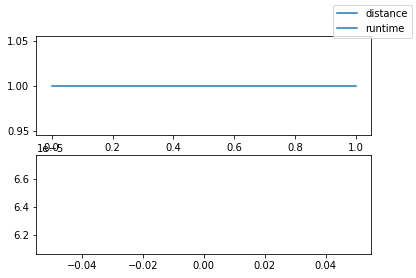

--------------------------------------------------------------------------------


In [100]:
tsp = main()